# Problem Set 1 - K-Nearest Neighbor and NaiveBayes classifiers
## CSCI 5622 - Fall 2022


Student name: Ashutosh Gandhi (110567529)   
Only submit this notebook to canvas (no zip files).

For today's assignment, we will be implementing our own K-Nearest Neighbors classifier (KNNClassifier) algorithm and a Naive Bayes classifier. 

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to
learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there
(should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors
import data
import tests
import math
%matplotlib inline

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*
 Yes - but it also has a ton of helper functions that we'll be using later.

You will be guided through the different questions and you'll be expected to complete the classes and the functions following the provided signatures.
 Sometimes at the end of a question we would provide a difficulty estimate using
the average scored by students who attempted the question (or a similar one) in previous assignments.

Remember to avoid adding positional arguments and make sure the returned values have the correct format (this applies to all assignments).
The alternative is that your solution might be rejected by the auto-grader (we won't be debugging your code).
We will provide some basic sanity checks. They're in no means exhaustive and passing them does not imply
your solution is 100% correct.


For example, you're required to complete the method `compute_something` of class A.
We provide examples of acceptable solutions.

First, let's also load a dataset to play with and start working to build out our own classifier.

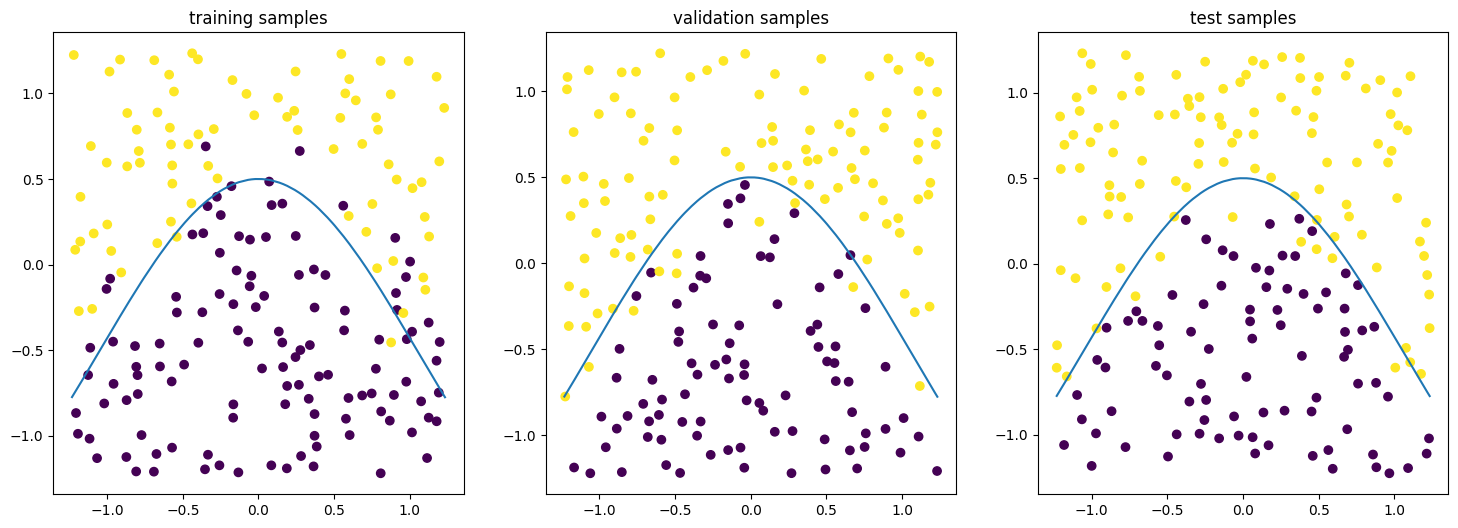

In [74]:
binary_data = data.BinaryData()
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
for i, name in enumerate(["training", "validation", "test"]):
    axs[i].plot(*binary_data.boundary())
    axs[i].set_title("%s samples" % name)
axs[0].scatter(binary_data.X_train[:, 0], binary_data.X_train[:, 1], c=binary_data.y_train)
axs[1].scatter(binary_data.X_valid[:, 0], binary_data.X_valid[:, 1], c=binary_data.y_valid)
axs[2].scatter(binary_data.X_test[:, 0], binary_data.X_test[:, 1], c=binary_data.y_test)
plt.show()

We have data! The `binary_data` instance has the following attributes:
   - a training set (`X_train, y_train`): to train the model and on which the prediction is based
   - a validation set (`X_valid, y_valid`): to select the best __hyper-parameters__ of the model
   - a test set (`X_test, y_test`): to evaluate the performance of the model on unseen data

### Problem 1: Complete our KNN Classifier - 30 Points

The KNNClassifier class we're implementing will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- A `fit` method that uses the training data
- A `predict` method that returns the predicted labels given data `X`

We've written out a lot of the structure for you for consistency across different parts of the assignment and so
you can focus on the "important" stuff that actually relates to the machine learning itself.

In [77]:
class KNNClassifier:

    def __init__(self, k=5):
        """
        Initialize our custom KNN classifier
        :param k: the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._ball_tree = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None
        self.population_most_common = None

    def fit(self, X, y):
        """
        Fit the model using the provided data
        :param X: 2-D np.array of shape (number training samples, number of features)
        :param y: 1-D np.array of shape (number training samples,)
        :return: self
        """
        self._ball_tree = sklearn.neighbors.BallTree(X)  # See documentation of BallTree and how it's used
        self._y = y
        # Should be used to map the classes to {0,1,..C-1} if needed (C is the number of classes)
        # We can assume that the training data contains samples from all the possible classes
        classes = np.unique(y)
        self.label_to_index = dict(zip(classes, range(classes.shape[0])))
        self.index_to_label = dict(zip(range(classes.shape[0]), classes))

        label_values, label_counts = np.unique(y, return_counts=True)
        self.training_most_common = label_values[np.argmax(label_counts)]

        return self

    def majority_vote(self, indices_nearest_k, distances_nearest_k=None):
        """
        Given indices of the nearest k neighbors for each point, report the majority label of those points.
        :param indices_nearest_k: np.array containing the indices of training neighbors, of shape (M, k)
        :param distances_nearest_k: np.array containing the corresponding distances of training neighbors, of shape (M, k)
        :return: The majority label for each row of indices, shape (M,)
        """

        # Workspace 1.1
        # TODO: Determine majority for each row of indices_nearest_k
        # TODO: if there is a tie, set the label to the most common label in the training set
        #BEGIN
        
        # voted_labels = np.empty(indices_nearest_k.shape[0]) # You can replace this
        # code here
        voted_labels = np.empty(indices_nearest_k.shape[0])

        for ind, row in enumerate(indices_nearest_k):
            class_map = dict.fromkeys(list(self.label_to_index.keys()), 0)
            for class_label in np.nditer(row):
                class_map[self._y[class_label]] += 1
            if len(list(set(list(class_map.values())))) == 1: # incase of tie set it to the most common class label
                voted_labels[ind] = self.training_most_common # TODO catch the tie for multi class
            voted_labels[ind] = max(class_map, key=class_map.get) # picking the majority

        #END
        return voted_labels

    def predict(self, X):
        """
        Given new data points, classify them according to the training data provided in fit and number of neighbors k
        You should use BallTree to get the distances and indices of the nearest k neighbors
        :param X: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """
        # Workspace 1.2
        #BEGIN 
        # code here
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, self._k)
        #END
        return self.majority_vote(indices_nearest_k, distances_nearest_k)

    def confusion_matrix(self, X, y):
        """
        Generate the confusion matrix for the given data
        :param X: an np.array of feature vectors of points, shape (N, n_features)
        :param y: the corresponding correct classes of our set, shape (N,)
        :return: a C*C np.array of counts, where C is the number of classes in our training data
        """
        # Workspace 1.3
        # The rows of the confusion matrix correspond to the counts from the true labels, the columns to the predictions'
        # TODO: Run classification for the test set X, compare to test answers y, and add counts to matrix
        #BEGIN 

        # c_matrix = np.zeros((len(self.label_to_index), len(self.label_to_index)))
        # predicted_value = self.predict(X)
        # # print(predicted_value)
        # for ind, val in enumerate(y):
        #     if val == predicted_value[ind] and val == 1: # true positive
        #         c_matrix[1][1] += 1
        #     elif val == predicted_value[ind] and (val == 0 or val == -1): # true negative
        #         c_matrix[0][0] += 1
        #     elif val != predicted_value[ind] and val == 1: # false negative
        #         c_matrix[1][0] += 1
        #     else: # false positive
        #         c_matrix[0][1] += 1
        
        num_classes = len(self.index_to_label)
        predicted = self.predict(X)
        c_matrix = np.zeros((num_classes, num_classes))
        for i in range(num_classes):
            for j in range(num_classes):
                c_matrix[i][j] = np.sum((y == self.index_to_label[i]) & (predicted == self.index_to_label[j]))
        # code here
        #END
        return c_matrix

    def accuracy(self, X, y):
        """
        Return the accuracy of the classifier on the data (X_test, y_test)
        :param X: np.array of shape (m, number_features)
        :param y: np.array of shape (m,)
        :return: accuracy score [float in (0,1)]
        """
        # Workspace 1.4
        # TODO: Compute accuracy on X
        #BEGIN 
        c_matrix = self.confusion_matrix(X, y)
        # score = (c_matrix[0][0] + c_matrix[1][1])/(c_matrix[0][0] + c_matrix[0][1] + c_matrix[1][0] + c_matrix[1][1])
        score = np.sum(c_matrix.diagonal()) / np.sum(c_matrix)
        # code here
        #END
        return score

In [78]:
# Test cell, uncomment to run the tests
tests.testKNN(KNNClassifier)

Question 1.1: [PASS]
Question 1.2: [PASS]
Question 1.3: [PASS]
Question 1.4: [PASS]


*But professor, this code isn't complete!*

1.1 [5 points] Complete the `majority_vote` function to determine the majority class of a series of neighbors.
If there is a tie, then you should remove the farthest element until the tie is broken. (Avg __4.6__)

1.2 [5 points] Complete the `predict` function to capture the predicted class of a new datapoint (Avg __4.9__)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.3 [5 points] Complete the `confusion_matrix` function to reveal the results of classification (Avg __5__)

1.4 [5 points] Complete the `accuracy` function to get accuracy of the classifier based on a given test data (Avg __5__)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

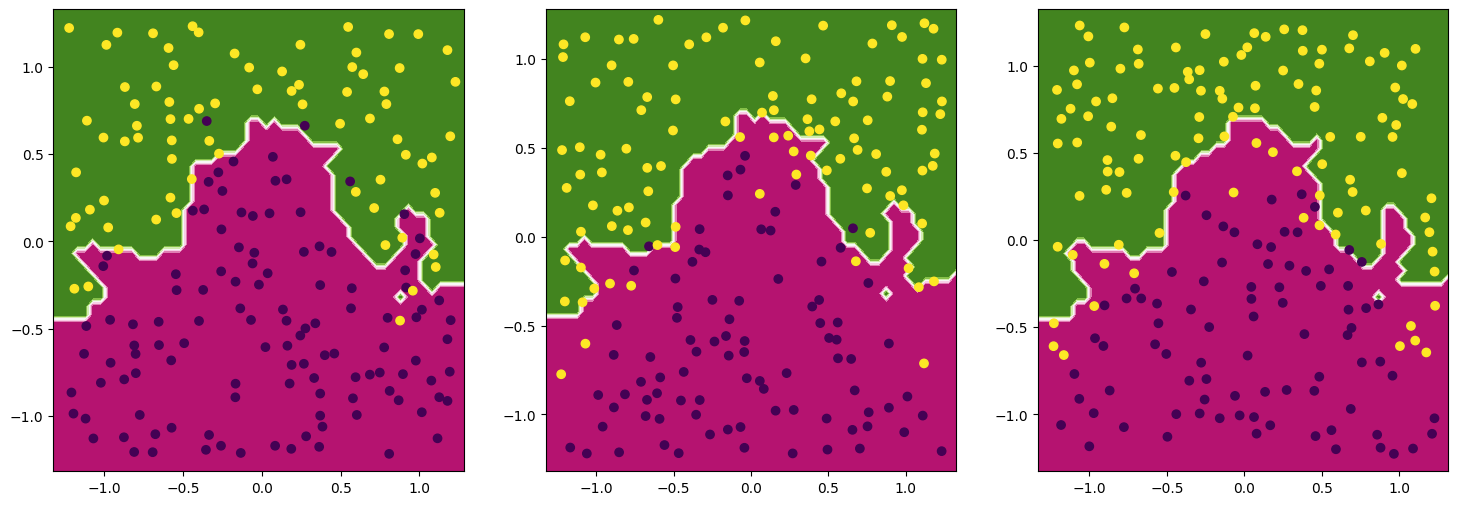

In [79]:
# This cell is to show the decision surface of the classifier
# You can change k to visualize KNN behavior
knn = KNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
tests.show_decision_surface(knn, binary_data.X_train, binary_data.y_train, axs[0])
tests.show_decision_surface(knn, binary_data.X_valid, binary_data.y_valid, axs[1])
tests.show_decision_surface(knn, binary_data.X_test, binary_data.y_test, axs[2])
plt.show()

1.5 [5 points] For each k in the range [1,32], fit a KNNClassifier on the training set and plot the accuracies on training and validation
data versus k. What's the value of k that yields the best accuracy on the training set? on the validation set? Which one
 should we choose? (Avg __4.8__)

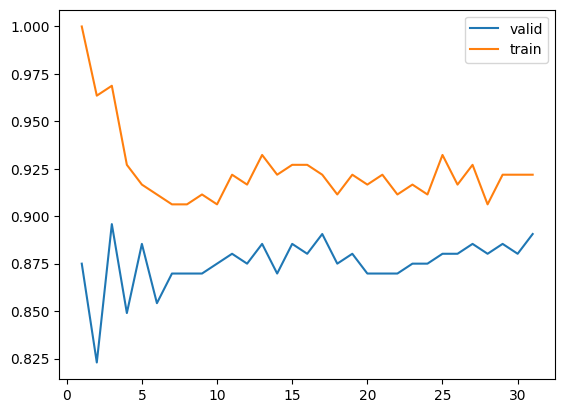

In [205]:
# Workspace 1.5.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    knn = KNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    accuracies_train.append(knn.accuracy(binary_data.X_train, binary_data.y_train))
    accuracies_valid.append(knn.accuracy(binary_data.X_valid, binary_data.y_valid))
    #BEGIN 
    # code here
    #END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

# print(accuracies_valid)
# print(max(accuracies_valid))
# print(accuracies_valid.index(max(accuracies_valid)) + 1)

### # Workspace 1.5.b
% Write up: best k for training and validation sets, and which one should we choose

% k = 1 for training 
% k = 3 for validation

% choose k=3 because it has the best accuracy in the validation set. 

1.6 [5 points] Report the accuracy and the confusion matrix on the test set using the value of k chosen in 1.5 (Avg __5__)

In [170]:
# Workspace 1.6
# TODO: print the accuracy and confusion matrix on the test set using k from 1.5
#BEGIN 
knn = KNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
accuracy = knn.accuracy(binary_data.X_test, binary_data.y_test)
c_matrix = knn.confusion_matrix(binary_data.X_test, binary_data.y_test)
print("Accuracy is {}".format(accuracy))
print("Confusion matrix is \n {}".format(c_matrix))
#END

Accuracy is 0.890625
Confusion matrix is 
 [[81.  2.]
 [19. 90.]]


**Bonus (for the avid machine learner) (4 Points)**

1.7.a [1 point] A [__consistent classifier__](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf)
on the training data is defined as a classifier that reaches 100% accuracy on the training set. For which values of k is KNNClassifier Consistent? (Avg __0.5__)

1.7.b [2 points] Edit your `KNNClassifier` so that it's consistent for all $k$ (we made sure that the change does not affect the sanity checks) (Avg __1__)

#### Write-up for the bonus
**Workspace 1.7.a**

% for which k in KNNClassifier consistent

% for k=1 KNN Classifier is consistent as the training accuracy on it was 100% as can be seen from the graph above. To make the KNNClassifier consistent we can add weights to each point as the inverse of the distance. The implementation of this is done below in section 3. As can be seen from the graph in section 3.3a the accuracy is 100% across the training set.

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?


### Problem 2: Improving KNN on Digits dataset - 20 Points

2.1 [4 points] `report` the number of examples different partitions of the digit dataset adn the number of pixels in the images (Avg __3.8__)

2.2 [6 points] complete the `evaluate` to perform the same evaluation we did in 1.5:
 - For k in range (1, 20):
    - initialize the classifier for k  and train in on the training set
    - Compute the accuracy on the validation set and save it
 - Choose k with the best accuracy on the validation set
 - Report the accuracy and the confusion matrix on the test set (use `display_confusion` for a cleaner output)


In [195]:
class Numbers:
    def __init__(self):
        self.data = data.DigitData() # it has the same structure as binary_data

    def report(self):
        """
        Report information about the dataset using the print() function
        """
        # Workspace 2.1
        #TODO: Create printouts for reporting the size of each set and the size of each datapoint
        #BEGIN 
        print("The training set consists of {} images".format(self.data.X_train.shape[0]))
        print("The validation set consists of {} images".format(self.data.X_valid.shape[0]))
        print("The testing set consists of {} images".format(self.data.X_test.shape[0]))
        print("The number of pixels in each image is {}".format(self.data.X_train.shape[1]))
        # code here
        #END

    def evaluate(self, classifier_class):
        """
        evaluates instances of the classifier class for different values of k and performs model selection
        :param classifier_class: Classifier class (either KNNClassifier or WeightedKNNClassifier)
        """

        # Workspace 2.2
        #BEGIN 
        # code here (anything between BEGIN and END is yours to edit if needed)
        best_valid_k = None
        confusion_matrix = None
        accuracy = 0
        ks = list(range(1, 20))
        accuracies_valid = []
        for k in ks:
            print(k, end="\r")
            knn = classifier_class(k).fit(self.data.X_train, self.data.y_train)
            k_accuracy = knn.accuracy(self.data.X_valid, self.data.y_valid)
            if k_accuracy > accuracy:
                accuracy = k_accuracy
                best_valid_k = k
            
            accuracies_valid.append(k_accuracy)
        #END
        knn = classifier_class(best_valid_k).fit(self.data.X_train, self.data.y_train)
        confusion_matrix = knn.confusion_matrix(self.data.X_test, self.data.y_test)
        accuracy = knn.accuracy(self.data.X_test, self.data.y_test)
        print("best k:", best_valid_k)
        print("Accuracy on test set:", accuracy)
        print("Confusion matrix is:")
        self.display_confusion(confusion_matrix)

    def view_digit(self, index, partition):
        """
        Display a digit given its index and partition
        :param index: index of the digit image
        :param partition: partition from which the digit is retrieved, either "train", "valid" or "test"
        """
        image = {"train": self.data.X_train, "valid": self.data.X_valid, "test": self.data.X_test}[partition][index]
        label = {"train": self.data.y_train, "valid": self.data.y_valid, "test": self.data.y_test}[partition][index]
        image = image.reshape(28, 28)
        plt.figure()
        plt.matshow(image)
        plt.title("Digit %i" % label)
        plt.show()

    @staticmethod
    def display_confusion(c_matrix):
        """
        Displays the confusion matrix using matshow
        :param c_matrix: square confusion matrix, shape (num_classes, num_classes)
        """
        _, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j, i]), va='center', ha='center')
        plt.show()


The training set consists of 1000 images
The validation set consists of 500 images
The testing set consists of 500 images
The number of pixels in each image is 784
best k: 4
Accuracy on test set: 0.868
Confusion matrix is:


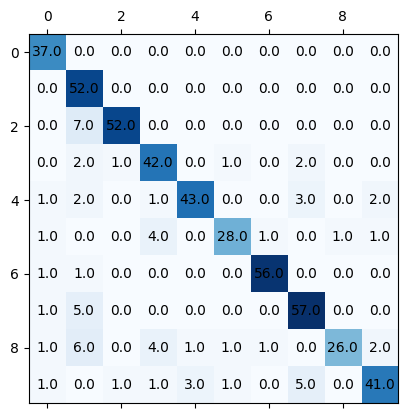

In [196]:
# Run evaluate of Numbers and shopws the confusion matrix
numbers = Numbers()
numbers.report()
numbers.evaluate(KNNClassifier)

*Wow, I can't believe we just created a KNN Classifier for multiple classes - but can't we make it better?*

Yes, we saw above that our classifier didn't work perfectly. Let's explore try to understand why.


2.3 [10 points] Determine which classes are most often confused (from our confusion matrix above),
 inspect some examples of these digits (using the `view_digit` function in our Numbers class),
 and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (Avg __9.1__)

The error rates for all digits in test data set is:
{0: 0.0, 1: 0.0, 2: 7.0, 3: 6.0, 4: 9.0, 5: 8.0, 6: 2.0, 7: 6.0, 8: 16.0, 9: 12.0}


<Figure size 640x480 with 0 Axes>

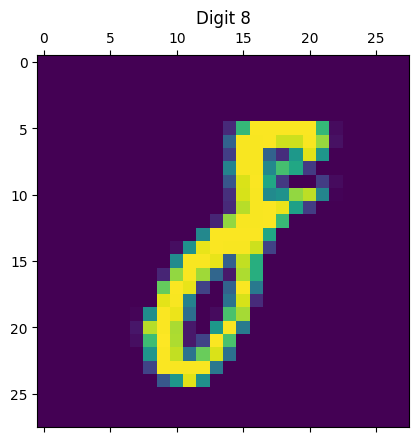

Predicted as 1.0 instead of 8


<Figure size 640x480 with 0 Axes>

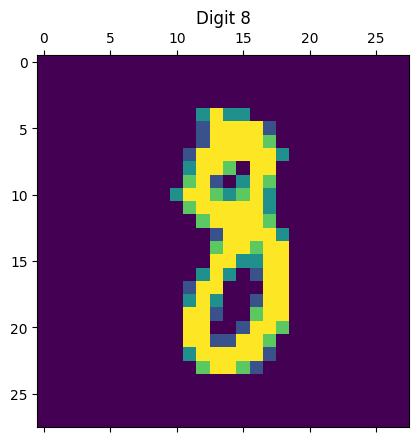

Predicted as 1.0 instead of 8


<Figure size 640x480 with 0 Axes>

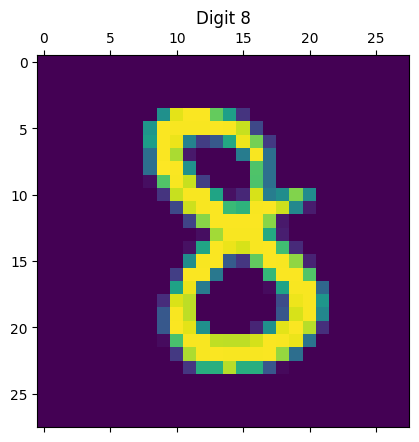

Predicted as 3.0 instead of 8


<Figure size 640x480 with 0 Axes>

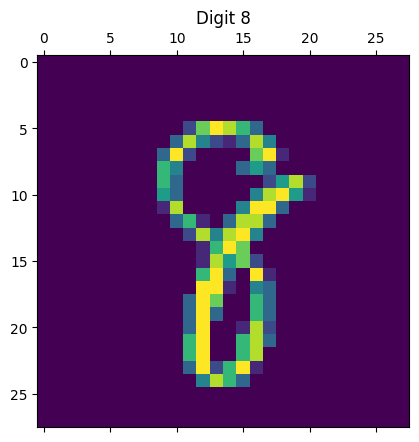

Predicted as 1.0 instead of 8


<Figure size 640x480 with 0 Axes>

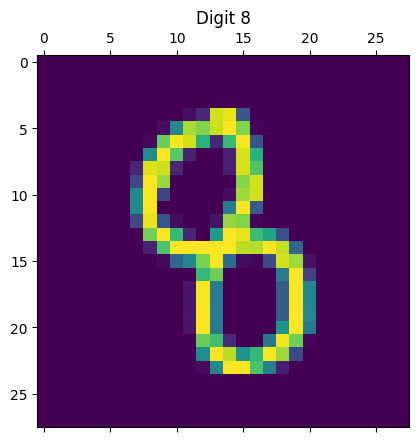

Predicted as 3.0 instead of 8


<Figure size 640x480 with 0 Axes>

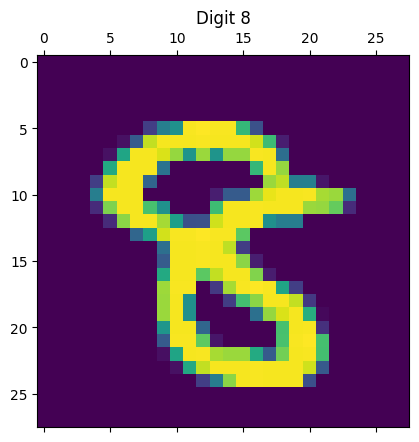

Predicted as 3.0 instead of 8


<Figure size 640x480 with 0 Axes>

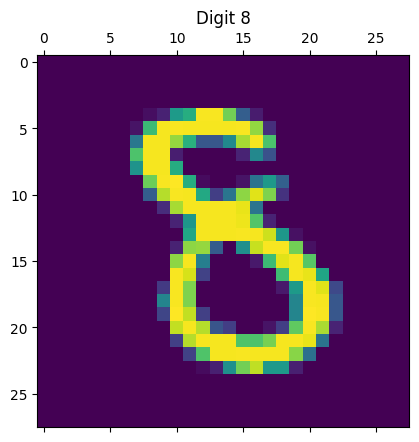

Predicted as 3.0 instead of 8


<Figure size 640x480 with 0 Axes>

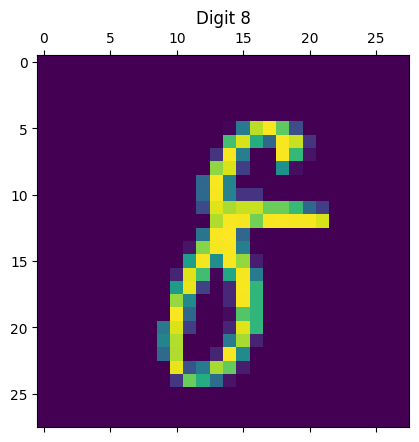

Predicted as 1.0 instead of 8


<Figure size 640x480 with 0 Axes>

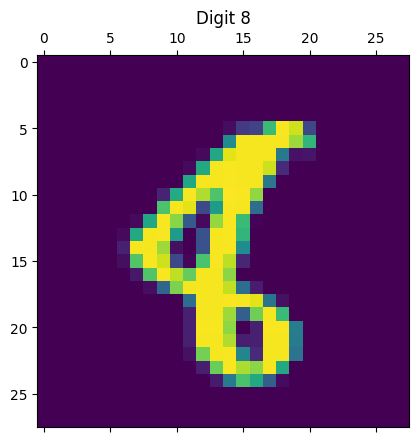

Predicted as 1.0 instead of 8


<Figure size 640x480 with 0 Axes>

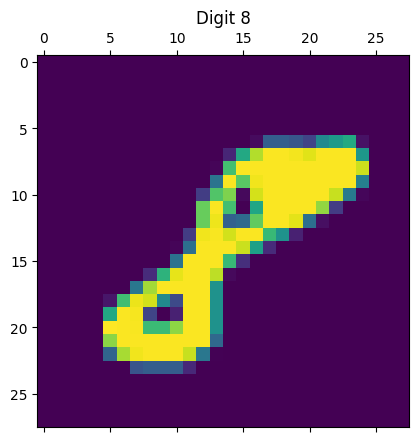

Predicted as 1.0 instead of 8


In [164]:
# Workspace 2.3.a
#TODO: Print out problem class images
#BEGIN 
# code here
numbers = Numbers()
knn = KNNClassifier(4).fit(numbers.data.X_train, numbers.data.y_train) # k=4 has the best accuracy

# identify error rate for each digit in the test set
confusion_matrix = knn.confusion_matrix(numbers.data.X_test, numbers.data.y_test)
c = confusion_matrix.shape[0]

error_rate = {}

for i in range(c):
    errors = 0
    for j in range(c):
        if i!=j:
            errors += confusion_matrix[i][j] 
    error_rate[i] = errors


print("The error rates for all digits in test data set is:")
print(error_rate)

indices_of_8_in_test_set = np.where(numbers.data.y_test==8)[0] # tuple to numpy array
# print(indices_of_8_in_test_set)
pred = knn.predict(numbers.data.X_test)
for ind in indices_of_8_in_test_set:
    if pred[ind] != 8 and (pred[ind] == 1 or pred[ind] == 3): # show all the occurrences of 8 predicted as either 1 or 3
        numbers.view_digit(ind, "test")
        print("Predicted as {} instead of 8".format(pred[ind]))
#END

**Workspace 2.3.b**

TODO: Write description of mis-classification

% The most misclassified digit is 8 with a total of 16 mis-classifications among the 42 entries in the test data set. It is incorrectly classified as 1 six times and as 3 four times. The above code snippet prints out each of this 9 occurrence's. From the above images we can deduce that when the circular hollow in the digit-8 is very small, the classifier tends to classify it as the digit-1 and when it is more wider and slanting from the left it tends to be classified as digit-3. The second most mis-classified digit is 9, it is mis-classified as 7 five times. This again can be explained based on the width of the hollow circle in 9, when it is smaller then it tends to be mis-classified as a 7. 

The mis-classification for other digits in the test data set is shown in the below dictionary.  
{0: 0.0, 1: 0.0, 2: 7.0, 3: 6.0, 4: 9.0, 5: 8.0, 6: 2.0, 7: 6.0, 8: 16.0, 9: 12.0} 

### Problem 3 : Improving KNN on MNIST using WeightedKNN (25 pts)
Complete the `WeightedKNNClassifier` class to perform the weighted KNN classification.
The Weighted KNN classifier assigns weights to the nearest-neighbor training examples proportional to
 the inverse-distance from the training example to the query point.

Classification is performed by summing the weights associated with each class and predicting the class with the highest weighted-majority vote.
 Mathematically, we might describe the weighted-vote for a class $c$ as

\begin{align}
\textrm{Weighted-Vote}(c)(x) = \sum_{i \in {\cal N}_K(x)} I(y_i \in c) \times \frac{1}{\|{\bf x}_i - {\bf x}\|}
\end{align}

where ${\cal N}_K(x)$ is the set of the nearest $k$ neighbors to $x$.

3.1 [10 points] Complete `weighted_vote`: it's certainly possible that a query point could be distance $0$ away from some training example.
 If this happens your implementation should handle it and return the appropriate class label.(Avg __7.8__)

3.2 [5 points] Complete `predict`. (Avg __4.9__)


In [187]:
class WeightedKNNClassifier(KNNClassifier):

    def get_max_weight(self, class_weight_map):

        max_keys = [key for key, value in class_weight_map.items() if value == max(class_weight_map.values())]

        if len(max_keys) == 1:
            return max(class_weight_map, key=class_weight_map.get)
        else:
            class_weight_map.pop(min(class_weight_map, key=class_weight_map.get)) # not considering the furthest point
            return self.get_max_weight(class_weight_map)


    def weighted_vote(self, indices_nearest_k, distances_nearest_k):
        """
        Given indices of nearest neighbors in training set, return the majority label. 
        Break ties by considering 1 fewer neighbor until a clear winner is found. 

        :param indices_nearest_k: The indices of the K nearest neighbors in self.X_train
        :param distances_nearest_k: Corresponding distances from query point to K nearest neighbors.
        """

        # Workspace 3.1
        #BEGIN 
        labels = np.empty((indices_nearest_k.shape[0]))  #REPLACE
        for i, row in enumerate(distances_nearest_k):
            class_weight_map = dict.fromkeys(list(self.label_to_index.keys()), 0)
            for j, dist in enumerate(row):
                index = indices_nearest_k[i][j]
                class_weight_map[self._y[index]] += ((1/dist) if dist > 0 else float('inf')) # computing the weight for each class label. infinite if the distance is 0 
            # print(class_weight_map)
            # labels[i] = max(class_weight_map, key=class_weight_map.get) # TODO implement condition in case of a tie

            # max_keys = [key for key, value in class_weight_map.items() if value == max(class_weight_map.values())]

            # if len(max_keys) > 1: # breaking the tie
            #     class_weight_map.pop(min(class_weight_map, key=class_weight_map.get)) # not considering the furthest point
            #     labels[i] = max(class_weight_map, key=class_weight_map.get)
            # else:
            #     labels[i] = max(class_weight_map, key=class_weight_map.get)
            
            labels[i] = self.get_max_weight(class_weight_map)

        # code here
        #END

        return labels

    def predict(self, X):
        """
        Given an np.array of query points, return y_hat, an np.array of predictions
        :param X: an (m x p) dimension np.array of points to predict labels for
        """

        # Workspace 3.2
        ##BEGIN 
        # code here
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, self._k)
        labels = self.weighted_vote(indices_nearest_k, distances_nearest_k)
        #END
        return labels

In [188]:
# Test cell, uncomment to run the tests
tests.testWeightedKNN(WeightedKNNClassifier)

Question 3.1: [PASS]
Question 3.2: [PASS]


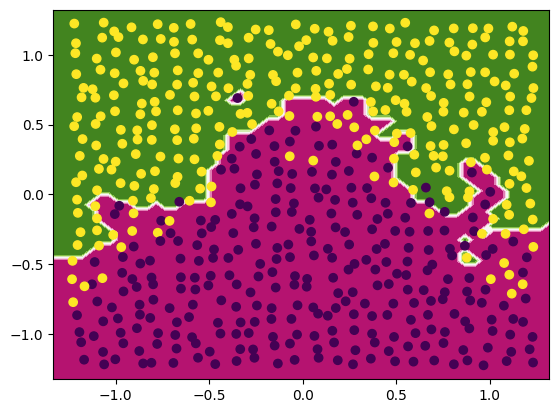

In [189]:
# Example on how to use the show_decision_surface
knn = WeightedKNNClassifier(3).fit(binary_data.X_train, binary_data.y_train)
tests.show_decision_surface(knn, binary_data.X, binary_data.y)

3.3 [5 points] Evaluate `WeightedKNNClassifier` on the binary data, similar to 1.5 digits data using `Numbers` class and compare it to `KNNClassifier` (Avg __4.6__)

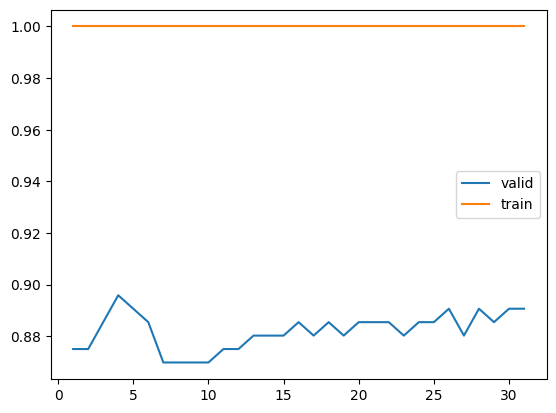

best value of k is 4
confusion matrix is:
[[80.  3.]
 [21. 88.]]
accuracy on test set is:
0.875


In [207]:
# Workspace 3.3.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    #BEGIN 
    knn = WeightedKNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    accuracies_train.append(knn.accuracy(binary_data.X_train, binary_data.y_train))
    accuracies_valid.append(knn.accuracy(binary_data.X_valid, binary_data.y_valid))
    #END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()
# print(np.max(accuracies_valid))
# print(accuracies_valid)
# print(accuracies_valid.index(max(accuracies_valid)))

print("best value of k is {}".format(accuracies_valid.index(max(accuracies_valid)) + 1))

knn = WeightedKNNClassifier(4).fit(binary_data.X_train, binary_data.y_train)
print("confusion matrix is:")
print(knn.confusion_matrix(binary_data.X_test, binary_data.y_test))
print("accuracy on test set is:")
print(knn.accuracy(binary_data.X_test, binary_data.y_test))

### # Workspace 3.3.b
% Write up: Which classifier does better on the binary data

% The best validation accuracy for all values of K from 1-32 is the same in case of both KNN and Weighted KNN. The accuracy being 89.58% for K=3 in KNN and k=4 in weighted KNN. But the test accuracy reduces by ~1.5% (from 89.06 to 87.5) with Weighted KNN compared to KNN. In conclusion, KNN does better classification of the binary data compared to weighted KNN.  



3.4 [5 points] Compare `WeightedKNNClassifier` to `KNNClassifier` on the digits' data using `Numbers` class.

WeightedKNNClassifier
best k: 4
Accuracy on test set: 0.894
Confusion matrix is:


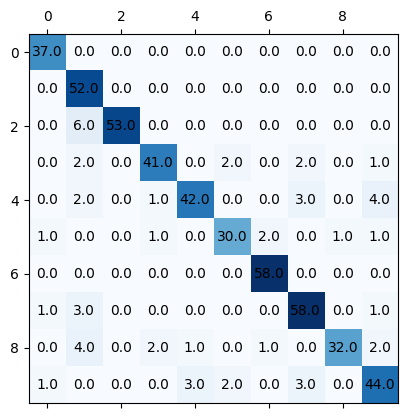



KNNClassifier
best k: 4
Accuracy on test set: 0.868
Confusion matrix is:


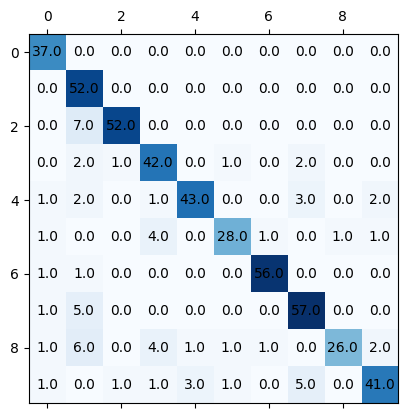

In [209]:
#Workspace 3.4.a
#BEGIN 
# code here
numbers = Numbers()
# numbers.report()
print("WeightedKNNClassifier")
numbers.evaluate(WeightedKNNClassifier)

print("\n\nKNNClassifier")
numbers.evaluate(KNNClassifier)
#END


#### 3.4.b write-up
% WeightedKNN classifier does a better job on the MNIST digits dataset compared to KNNClassifier. The best accuracy in case of WeightedKNN classifier is 2.6% more than that of KNNClassifier for the test data set.

#### Bonus
3.5 [2 points] Is `WeightedKNNClassifier` a consistent classifier? why? (Avg __1.1__)


#### 3.5 write-up
% Yes WeightedKNNClassifier is a consistent classifier as it has a training accuracy of 1 for all values of K. Since the weights are calculated as the inverse of the distance of the nearest k neighbors a higher weight would be given to the nearest sample point compared to the other k-1 neighbors. For example in case of K=3 if we have one sample point at a distance of 0.5 with the label 0 and the other 2 points at a distance of 1.5 and 1.7 each with labels 1 then WeightedKNN would classify it as 0 since it would have a higher weight (2) compared to that of label 1 (1.25) but in case of KNNClassifier the majority vote would go to label 1 as it is has majority vote of 2 vs 1. 

### Problem 4 - Naive Bayes [25 points]
***
Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency.
The dataset looks like the following.

|Age|Salary|Colorado Resident| Has Siblings | College degree|
|:------:|:-----------:| :----------:| :----------:|--:|
| 37 | 44,000 | Yes | No  | Yes|
| 61 | 52,000 | Yes | No  | No |
| 23 | 44,000 | No  | No  | Yes|
| 39 | 38,000 | No  | Yes | Yes|
| 48 | 49,000 | No  | No  | Yes|
| 57 | 92,000 | No  | Yes | No |
| 38 | 41,000 | No  | Yes | Yes|
| 27 | 35,000 | Yes | No  | No |
| 23 | 26,000 | Yes | No  | No |
| 38 | 45,000 | No  | No  | No |
| 32 | 50,000 | No  | No  | Yes|
| 25 | 52,000 | Yes | No  | Yes|


In [120]:
features = np.array([
    [37, 44000, 1, 0],
    [61, 52000, 1, 0],
    [23, 44000, 0, 0],
    [39, 38000, 0, 1],
    [48, 49000, 0, 0],
    [57, 92000, 0, 1],
    [38, 41000, 0, 1],
    [27, 35000, 1, 0],
    [23, 26000, 1, 0],
    [38, 45000, 0, 0],
    [32, 50000, 0, 0],
    [25, 52000, 1, 0]
])
labels = np.array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

4.1 [3 points] Complete `threshold_features` to convert age and salary features to binary ones using the threshold arguments. (Avg __2.9__)

In [121]:
def threshold_features(features, age_threshold, salary_threshold):
    """
    Transform age and salary to binary
    :param features: data array of shape (m, n_features) where features[:,0] for age, features[:,1} for salary
    :param age_threshold: used to "binarize" the data, 1 if age > age_threshold and 0 otherwise
    :param salary_threshold: used to "binarize" the data, 1 if salary > salary_threshold and 0 otherwise
    :return: binary features matrix
    """
    binary_features = features * 1  #This row just creates a "hard copy" of the X array so we can manipulate it as needed

    # Workspace 4.1
    #BEGIN
    binary_features[:,0]=np.where(features[:,0] > age_threshold, 1, 0)
    binary_features[:,1]=np.where(features[:,1] > salary_threshold, 1, 0)
    #END

    return binary_features

In [122]:
# Test cell, uncomment to run the tests
tests.test_threshold(threshold_features)

Question 4.1: [PASS]


4.2 [2 points] If we were to use only one binary feature (age >40, salary > 40000, colorado resident, has siblings),
then what's the highest accuracy we could achieve? Which feature should we use?

In [135]:
def calculate_accuracy(predicted, labels):
    # Calculating accuracy
    num_classes = 2
    c_matrix = np.zeros((num_classes, num_classes))
    index_to_label = {0:0, 1:1}
    for i in range(num_classes):
        for j in range(num_classes):
            c_matrix[i][j] = np.sum((labels == index_to_label[i]) & (predicted == index_to_label[j]))

    accuracy = np.sum(c_matrix.diagonal()) / np.sum(c_matrix)
    return accuracy

In [141]:
accuracy=calculate_accuracy(np.where(features[:,0] > 40, 1, 0), labels)
print("With age>40 accuracy = ", accuracy)

accuracy=calculate_accuracy(np.where(features[:,1] > 40000, 1, 0), labels)
print("With salary>40000 accuracy = ", accuracy)

accuracy=calculate_accuracy(features[:,2], labels)
print("With colorado resident is true accuracy = ", accuracy)

accuracy=calculate_accuracy(features[:,3], labels)
print("With has siblings accuracy = ", accuracy)

With age>40 accuracy =  0.3333333333333333
With salary>40000 accuracy =  0.6666666666666666
With colorado resident is true accuracy =  0.3333333333333333
With has siblings accuracy =  0.5


**Workspace 4.2**

% The Highest accuracy with only one feature considered is 0.67, achieved when considering only salary>40000 as the binary feature. 

## How to implement NaiveBayes
As seen during the class, given a row $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

For this, we need two attributes to store
$\log p(y)$ and $\log p(x_i | y)$ for different features $i$.

Let's assume we're working with binary classes $\{0, 1\}$ and all features have discrete supports.
Then we will store `classes_log_probability` as an array of shape `(2,)` that contains:
\begin{bmatrix}
\log p(y=0),\log p(y=1)
\end{bmatrix}.

If feature $i$ has $2$ possible values $\{0, 1\}$, then $\log p(x_i | y)$ would be stored as a $ 2 \times 2$ matrix:
\begin{align}
A_i = \begin{bmatrix}
\log p(x_i=0 | y=0) & \log p(x_i=1| y=0)\\
\log p(x_i=0 | y=1) & \log p(x_i=1 | y=1)
\end{bmatrix}
\end{align}

`features_log_likelihood` should then store such matrix for each feature.

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,x_i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,x_i}$.

4.3 [2 points] Complete the method `compute_classes` and store the log prior in `classes_log_probability` (Avg __2__)

4.4 [5 points] Complete the method `compute_features` by storing the matrices $A_i$ in `self.features_log_likelihood` (Avg __4.3__)

4.5 [5 points] Complete the method `join_log_likelihood` that computes the likelihood quantities
 $[\sum_{i} \log p(x_i | y=0), \sum_{i} \log p(x_i | y=1)]$ for each observation

4.6 [3 points] Complete the `predict` method

In [125]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.classes_log_probability = np.empty((2,))
        self.features_log_likelihood = []  # list of arrays where element i store log p(X[:,i], y)

    def compute_classes(self, y):
        """
        Computes the log prior of binary classes and stores the result in self.classes_log_probability
        :param y: binary labels array, shape (m,)
        """
        # Workspace 4.3
        #BEGIN 
        zero_count = np.count_nonzero(y == 0)
        one_count = np.count_nonzero(y == 1)
        total_count = zero_count + one_count
        self.classes_log_probability[0] = np.log(zero_count/total_count)
        self.classes_log_probability[1] = np.log(one_count/total_count)
        self.classes_counts = np.unique(y).size
        # print(self.classes_log_probability)
        # code here
        #END

    def compute_features(self, X, y):
        """
        Computes the log likelihood matrices for different features and stores them in self.features_log_likelihood
        :param X: data matrix with binary features, shape (n_samples, n_features)
        :param y: binary labels array, shape (n_samples,)
        """
        # Workspace 4.4
        #BEGIN 
        # code here
        
        for i in range(X.shape[1]):
            sub_array = np.zeros((2,2))
            for label in np.unique(y):
                for j in np.unique(X[:,i]):
                    sub_array[label][j] = np.sum(np.in1d(np.where(X[:,i] == j)[0], np.where(y == label)[0]))/np.where(y == label)[0].shape[0]
                    ## P(Xi|y) - np.sum(np.in1d(np.where(X[:,i] == j)[0], np.where(y == label)[0])) gets count of all matches between Xi and y
                    ## Ny - np.where(y == label)[0].shape[0] number of occurrence of a label in y
            self.features_log_likelihood.append(np.log(sub_array))
        #END

    def fit(self, X, y):
        """
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :param y: corresponding binary labels of shape (n_samples,) [values 0 or 1]
        :return: Classifier
        """
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        """
        Computes the joint log likelihood
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :return: joint log likelihood array jll of shape (n_samples, 2), where jll[i] = [log p(X[i]|y=0),log p(X[i]|y=1)]
        """
        # Workspace 4.5
        joint_log_likelihood = np.zeros((X.shape[0], 2))
        #BEGIN 
        # code here
        for num_sample in range(X.shape[0]): # iterate through all the samples
            x_array = X[num_sample]
            for y in range(self.classes_counts): # y=0 or y=1
                sum = 0
                for x in range(x_array.shape[0]): # iterate through all the features 
                    sum += self.features_log_likelihood[x][y][x_array[x]] # get log likelihood of Xi given y=0 or y=1
                joint_log_likelihood[num_sample][y] = sum
        #END
        return joint_log_likelihood

    def predict(self, X):
        """
        :param X:
        :return:
        """

        # Workspace 4.6
        # TODO: Find the corresponding labels using Naive bayes logic
        #BEGIN 
        # code here
        y_hat = np.zeros((X.shape[0],))
        for ind, val in enumerate(self.joint_log_likelihood(X)):
            y_hat[ind] = np.argmax(self.classes_log_probability + val)
        #END
        return y_hat

In [126]:
import tests
# Test cell, uncomment to run the tests
tests.test_NB(NaiveBayes)

Question 4.3: [PASS]
Question 4.4: [PASS]
Question 4.5: [PASS]
Question 4.6: [PASS]


4.7 [5 points] Using age 40 and salary 40,000 as thresholds, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. Does it outperform our baseline (of using one feature)? (Avg __4.5__)

In [137]:
naive_bayes = NaiveBayes()
# Workspace 4.5
#TODO: Transform features to binary features, fit the classifier, report the accuracy
#BEGIN 
# code here
transformed_features = threshold_features(features, 40, 40000)
naive_bayes.fit(transformed_features, labels)
predicted = naive_bayes.predict(transformed_features)
print("predicted", predicted)
print("actual", labels)

accuracy = calculate_accuracy(predicted, labels)
print("The accuracy of bayes model is {}".format(accuracy))

#END

predicted [1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]
actual [1 0 1 1 1 0 1 0 0 0 1 1]
The accuracy of bayes model is 0.8333333333333334


% Naive Bayes outperforms the baseline with a higher accuracy of 83.33% compared to the highest single feature accuracy of 66.67%.

**Bonus**

4.8 [2 points] Use the attribute `alpha` of the NaiveBayes to convert it to smoothed NaiveBayes presented during the class.
`alpha`defaults to 0, so editing the class should not affect NaiveBayes tests (Avg __1.8__)